# Sea Surface Temperature Analysis Notebook

This notebook demonstrates an end-to-end pipeline for processing MODIS L2P sea surface temperature (SST) data. It performs the following steps:

1.  **Import libraries** and set up the environment.
2.  **Search for and load** the satellite netCDF files.
3.  **Inspect file structure** to list variables.
4.  **Extract data on a GPU** using CuPy and parallel processing.
5.  **Clip, bin, and plot** the rasterized sea surface temperature data for the Texas-Louisiana Shelf.
6.  **Apply selective NaN interpolation** to the binned data and plot the result.

Below, the code cells document each step in detail.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, data manipulation, and plotting.

In [9]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr # For inspecting netCDF file structure

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
# Assuming l2_pipeline.py is in the same directory or accessible via PYTHONPATH
import l2_pipeline 
importlib.reload(l2_pipeline)

from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

### Searching for Data Files

This cell specifies the data directory and recursively searches for netCDF files containing satellite SST data.

In [10]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 86 files.


### Inspecting File Structure

This cell opens the first found netCDF file to list its variables, data variables, and coordinates. This helps confirm the names for 'sea_surface_temperature', 'latitude', and 'longitude'. MODIS L2P files typically store these in the root of the file.

In [11]:
# Inspect variables in the first netCDF file
if not nc_files:
    print("No netCDF files found to inspect.")
else:
    file_to_inspect = nc_files[0]
    print(f"Inspecting variables in: {file_to_inspect}\n")
    try:
        with xr.open_dataset(file_to_inspect) as ds:
            print("All Variables (including coordinates):")
            for var_name in ds.variables:
                print(f"  - {var_name}")
                print(f"    Dimensions: {ds[var_name].dims}")
                if hasattr(ds[var_name], 'attrs'):
                    if 'long_name' in ds[var_name].attrs:
                        print(f"    Long name: {ds[var_name].attrs['long_name']}")
                    if 'units' in ds[var_name].attrs:
                        print(f"    Units: {ds[var_name].attrs['units']}")
            
            print("\nData Variables:")
            for var_name in ds.data_vars:
                print(f"  - {var_name}")
                print(f"    Dimensions: {ds[var_name].dims}")
                if hasattr(ds[var_name], 'attrs'):
                    if 'long_name' in ds[var_name].attrs:
                        print(f"    Long name: {ds[var_name].attrs['long_name']}")
                    if 'units' in ds[var_name].attrs:
                        print(f"    Units: {ds[var_name].attrs['units']}")

            print("\nCoordinates:")
            for coord_name in ds.coords:
                print(f"  - {coord_name}")
                print(f"    Dimensions: {ds[coord_name].dims}")
                if hasattr(ds[coord_name], 'attrs'):
                    if 'long_name' in ds[coord_name].attrs:
                        print(f"    Long name: {ds[coord_name].attrs['long_name']}")
                    if 'units' in ds[coord_name].attrs:
                        print(f"    Units: {ds[coord_name].attrs['units']}")
                        
    except Exception as e:
        print(f"Error inspecting file {file_to_inspect}: {e}")

Inspecting variables in: E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30\20240601081500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

All Variables (including coordinates):
  - sea_surface_temperature
    Dimensions: ('time', 'nj', 'ni')
    Long name: sea surface temperature
    Units: kelvin
  - sst_dtime
    Dimensions: ('time', 'nj', 'ni')
    Long name: time difference from reference time
  - quality_level
    Dimensions: ('time', 'nj', 'ni')
    Long name: quality level of SST pixel
  - sses_bias
    Dimensions: ('time', 'nj', 'ni')
    Long name: SSES bias error based on proximity confidence flags
    Units: kelvin
  - sses_standard_deviation
    Dimensions: ('time', 'nj', 'ni')
    Long name: SSES standard deviation error based on proximity confidence flags
    Units: kelvin
  - l2p_flags
    Dimensions: ('time', 'nj', 'ni')
    Long name: L2P flags
  - sea_surface_temperature_4um
    Dimensions: ('time', 'nj', 'ni')
    Long name: sea surface

C:\Users\Makai\AppData\Local\Temp\ipykernel_48504\3171820746.py:8: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(file_to_inspect) as ds:


### Loading Datasets

Using the custom `L2DatasetLoader`, this cell loads multiple datasets from the discovered netCDF files. We specify `sea_surface_temperature` as the primary variable. Since MODIS L2P files often store `lat` and `lon` as 2D data variables rather than 1D coordinates, we include them in the `variables_to_load` list. `group=None` is used as these variables are typically in the root of the L2P files.

In [12]:
# Define the variable to plot and other necessary variables (lat, lon if they are data variables)
variable_to_plot = 'sea_surface_temperature'
# For MODIS L2P, lat and lon are often 2D data variables, so include them here.
variables_to_load = [variable_to_plot, 'lat', 'lon']

# Load datasets using L2DatasetLoader
# group=None because variables are expected in the root for these L2P files
loader = L2DatasetLoader(variables=variables_to_load, group=None) 
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

Loaded 86 datasets.


### GPU Data Extraction

This cell leverages the GPU with CuPy and parallel processing to extract and filter the satellite data. `lat` and `lon` are included in `variables_to_load` for the extractor because they are treated as data variables from the L2P files. The extractor will provide dedicated `all_lon_gpu` and `all_lat_gpu` arrays for geolocation.

In [13]:
# Create an instance of GPUDataExtractor and extract data on GPU
# Pass the same variables_to_load list as lat/lon are needed by the extractor
extractor = GPUDataExtractor(variables=variables_to_load)
all_lon_gpu, all_lat_gpu, all_vars_data_gpu = extractor.extract(datasets)

# Get the sea surface temperature data
all_sst_gpu = all_vars_data_gpu[variable_to_plot]

print(f"GPU data extraction complete. Extracted {len(all_lon_gpu)} points.")

GPU data extraction complete. Extracted 103134748 points.


### Binning and Plotting Sea Surface Temperature

This cell defines a bounding box for the Texas-Louisiana Shelf, clips the extracted SST data to this box, computes a 2D binned mean statistic, and then plots it on a map.

In [14]:
from scipy.stats import binned_statistic_2d

# === Define Bounding Box for the Texas-Louisiana Shelf ===
lon_min, lon_max = -98, -87  # Degrees West
lat_min, lat_max = 25, 30.5   # Degrees North

# === Clip data to the bounding box ===
# Ensure all arrays are 1D and have the same size
mask = (
    (all_lon_gpu >= lon_min) & (all_lon_gpu <= lon_max) &
    (all_lat_gpu >= lat_min) & (all_lat_gpu <= lat_max)
)
clipped_lon = all_lon_gpu[mask]
clipped_lat = all_lat_gpu[mask]
clipped_sst_kelvin = all_sst_gpu[mask]

# Convert SST from Kelvin to Celsius
clipped_sst = clipped_sst_kelvin - 273.15

print(f"Clipped data to {len(clipped_lon)} points within the bounding box.")
print(f"SST converted to Celsius.")

# === Define a minimum SST threshold in Celsius ===
# Values below this threshold will be treated as NaN
min_sst_celsius_threshold = -100.0 
clipped_sst[clipped_sst < min_sst_celsius_threshold] = np.nan
print(f"Applied SST threshold: values below {min_sst_celsius_threshold}°C are set to NaN.")

# === Define binning parameters ===
# Adjust bin numbers for desired resolution
lat_bins_count, lon_bins_count = 200, 300 

# === Compute 2D binned mean statistic over the clipped data ===
# Check if there's any data to bin
if clipped_lon.size > 0 and clipped_lat.size > 0 and clipped_sst.size > 0:
    stat_sst, lat_edges, lon_edges, _ = binned_statistic_2d(
        clipped_lat, clipped_lon, clipped_sst, statistic='mean', 
        bins=[lat_bins_count, lon_bins_count],
        range=[[lat_min, lat_max], [lon_min, lon_max]]
    )
    # === Generate meshgrid for pcolormesh using bin edges ===
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    print("Binning complete.")
else:
    print("No data points found within the specified bounding box for binning. Skipping plotting.")
    stat_sst = None # Ensure stat_sst exists for later checks

Clipped data to 16736421 points within the bounding box.
SST converted to Celsius.
Applied SST threshold: values below -100.0°C are set to NaN.
Binning complete.


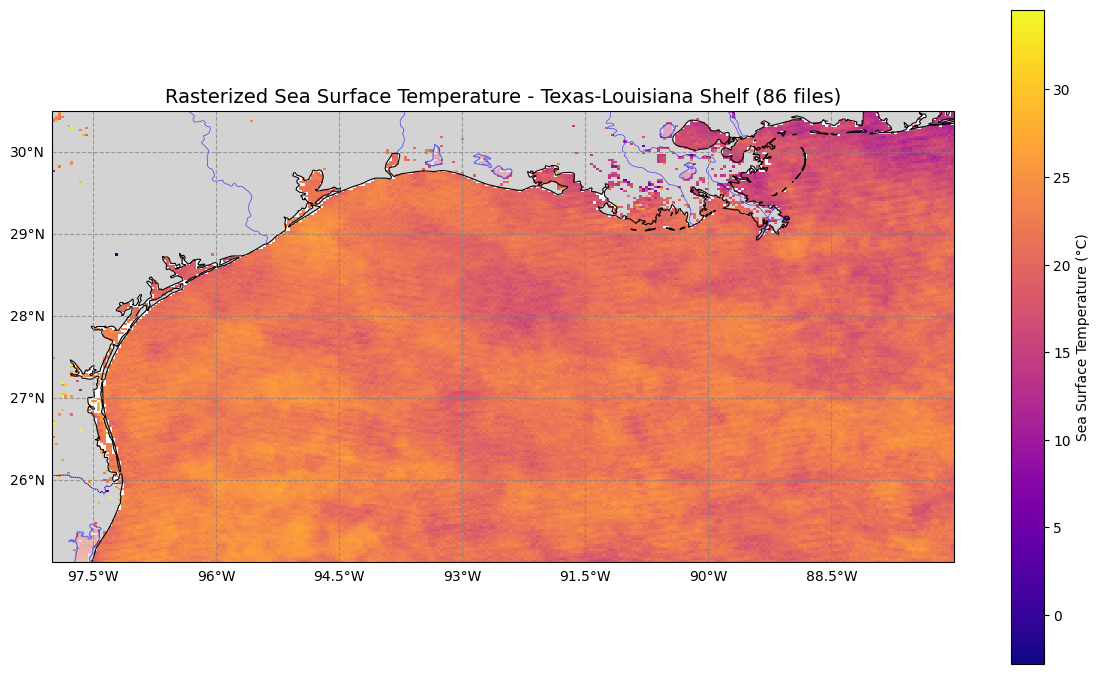

In [15]:
# === Plotting the Rasterized Sea Surface Temperature Map ===
if stat_sst is not None and np.any(~np.isnan(stat_sst)): # Check if there is data to plot
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent using the bounding box
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the raster data
    # Using 'plasma' or 'inferno' colormap which are good for temperature
    raster = ax.pcolormesh(
        lon_grid, lat_grid, stat_sst,
        cmap='plasma', shading='auto',
        transform=ccrs.PlateCarree()
    )

    # Add coastlines and land features for context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0) # zorder ensures land is behind coastlines
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.7)
    ax.add_feature(cfeature.LAKES, facecolor='aliceblue', edgecolor='blue', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    # Display a colorbar and map title
    cbar = plt.colorbar(raster, label='Sea Surface Temperature (°C)', shrink=0.85, pad=0.05)
    plt.title(f"Rasterized Sea Surface Temperature - Texas-Louisiana Shelf ({len(datasets)} files)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No valid binned SST data available.")

### Selective NaN Interpolation

This section uses the `SelectiveInterpolator` class from `l2_pipeline` to fill small gaps (NaN regions) in the binned SST data while preserving larger NaN regions. This can improve visual continuity without fabricating data over large missing areas.

Selective interpolation complete (threshold: 32 bins).


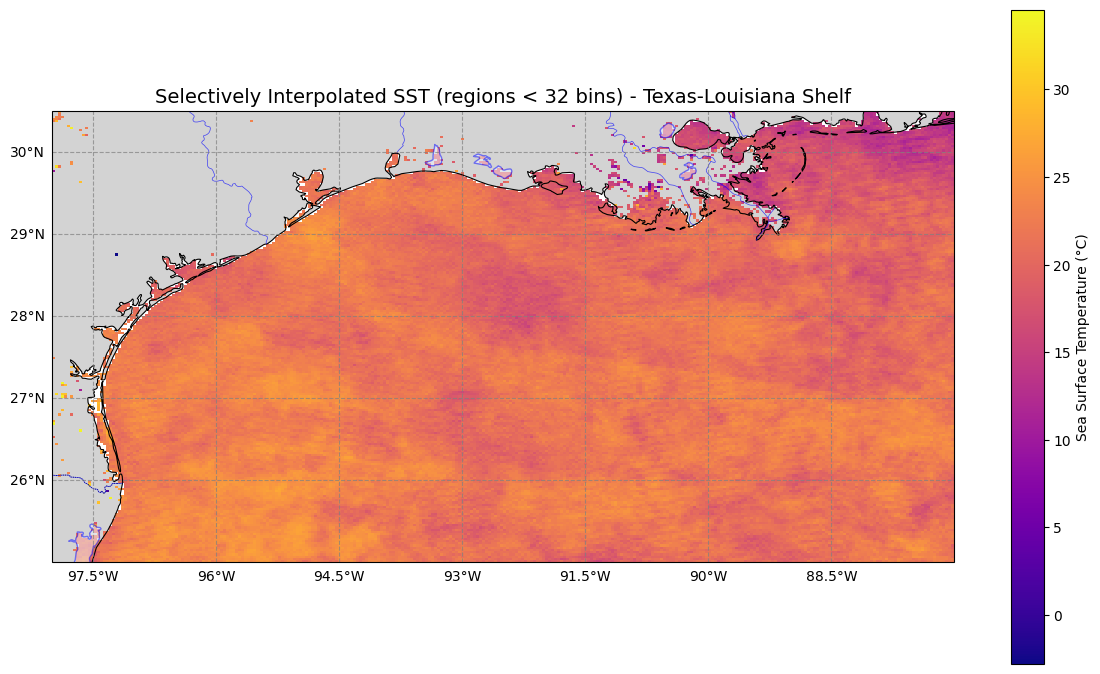

In [16]:
if stat_sst is not None and np.any(~np.isnan(stat_sst)): # Proceed only if there's some data
    # Set the threshold for small regions (regions with fewer connected bins than this will be interpolated)
    interpolation_threshold = 32  

    # Use the SelectiveInterpolator class for interpolation
    sst_selective_interp = SelectiveInterpolator.interpolate(stat_sst, lat_edges, lon_edges, threshold=interpolation_threshold)
    print(f"Selective interpolation complete (threshold: {interpolation_threshold} bins).")

    # Create a new figure for the selectively interpolated SST plot
    fig_interp = plt.figure(figsize=(12,8))
    ax_interp = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent
    ax_interp.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the selectively interpolated data
    raster_interp = ax_interp.pcolormesh(
        lon_grid, lat_grid, sst_selective_interp,
        cmap='plasma', shading='auto',
        transform=ccrs.PlateCarree()
    )

    # Add map features
    ax_interp.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax_interp.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_interp.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)
    ax_interp.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.7)
    ax_interp.add_feature(cfeature.LAKES, facecolor='aliceblue', edgecolor='blue', alpha=0.5)
    
    # Add gridlines
    gl_interp = ax_interp.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl_interp.top_labels = False
    gl_interp.right_labels = False

    # Display colorbar and title
    cbar_interp = plt.colorbar(raster_interp, label='Sea Surface Temperature (°C)', shrink=0.85, pad=0.05)
    plt.title(f"Selectively Interpolated SST (regions < {interpolation_threshold} bins) - Texas-Louisiana Shelf", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping selective interpolation plot: No valid binned SST data available.")